# 🌸 Hybrid Quantum–Classical Neural Network on the Iris Dataset

This notebook implements a **hybrid quantum-classical model** combining a **quantum neural network (QNN)** built with Qiskit and a classical neural layer in PyTorch.  
The goal is to classify samples from the **Iris dataset** (4 features: sepal length/width, petal length/width; 3 classes: setosa, versicolor, virginica).

### Why Hybrid?
Hybrid QNNs leverage quantum circuits as **trainable feature extractors**, followed by classical layers for decision-making.  
This allows exploration of near-term quantum computing while keeping classical efficiency.

### 🛠️ Experimental Setup & Evaluation
Before analysis, we:
- Set up the environment (**PyTorch, Qiskit, scikit-learn, Matplotlib**).  
- Preprocess the **Iris dataset** and prepare tensors for quantum encoding.  
- Build **quantum circuits** for both plain and richer encoding schemes.  
- Construct **QNNs** and integrate them into the hybrid model.  
- Load **trained model weights** and **previously saved metrics**.  

This setup enables all subsequent **evaluation and visualization**, including:  
- Training performance (loss & accuracy)  
- Test set evaluation (accuracy, confusion matrices, classification reports)  
- Quantum layer outputs and embeddings  
- Feature saliency and parameter sensitivity  
- Statistical tests (Wilcoxon) to compare encodings

---

## ⚛️ Technologies Used

- **Qiskit Machine Learning**: EstimatorV2, EstimatorQNN, TorchConnector  
- **PyTorch**: neural network and optimizer  
- **scikit-learn**: data handling, preprocessing, PCA  
- **AerSimulator**: local quantum circuit simulation  

---

### 🎯 Outcome
- Compare **plain vs richer encoding** performance  
- Visualize **quantum embeddings** and **feature importance**  
- Assess **parameter sensitivity** and **statistical significance** of differences  

*Part of the QAMP Project: “QNNs — Saliency & Sensitivity Kit”*

## 🛠️ Experimental Setup

### 🧩 Data and PyTorch Setup

In this section, we import the essential libraries required for data handling, preprocessing, and model training.  
- **PyTorch** is used to define, train, and evaluate our hybrid neural network model.  
- **scikit-learn** provides utilities for loading the **Iris dataset**, scaling features, and splitting data into training and testing sets.  
- Additional tools such as **NumPy**, **Matplotlib**, and **SciPy** are used for numerical computation, visualization, and statistical analysis.

In [1]:
# ===== 1. Core PyTorch modules =====
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset  # Efficient batching & dataset handling

# ===== 2. Machine Learning utilities (scikit-learn) =====
from sklearn.datasets import load_iris                  # Classic Iris dataset (4 features, 3 classes)
from sklearn.decomposition import PCA                   # Dimensionality reduction for visualization
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split    # Train/test splitting
from sklearn.preprocessing import StandardScaler        # Feature normalization

# ===== 3. Statistical analysis =====
from scipy.stats import wilcoxon                        # Non-parametric test (paired samples)

# ===== 4. Visualization & numerics =====
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

### ⚛️ Quantum Components (Qiskit Setup)
Here we import Qiskit Machine Learning modules to build and simulate a quantum neural network (QNN).  
We use `EstimatorV2` for evaluating circuits, `ParamShiftEstimatorGradient` for computing gradients,  
and `TorchConnector` to integrate the quantum model with PyTorch.

In [2]:
# Import Qiskit Machine Learning components
from qiskit_machine_learning.neural_networks import EstimatorQNN  # Quantum neural network wrapper

# Core Qiskit imports for building quantum circuits
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter  # Used to define trainable parameters (symbolic variables)

# Import AerSimulator for local quantum circuit simulation
from qiskit_aer import AerSimulator

# Import EstimatorV2 (modern replacement for Estimator primitive) for circuit evaluation
from qiskit_ibm_runtime import EstimatorV2

# Connector to bridge Qiskit QNNs with PyTorch modules
from qiskit_machine_learning.connectors import TorchConnector

# SparsePauliOp defines quantum observables (like measuring Pauli Z)
from qiskit.quantum_info import SparsePauliOp

# Gradient computation method using parameter-shift rule
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient

### 🎲 Reproducibility Setup

To ensure consistent and comparable results across runs, we fix all random seeds used by **PyTorch** and **NumPy**.  
This guarantees that data shuffling, weight initialization, and stochastic processes behave deterministically.

In [3]:
# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### ⚙️ Training Hyperparameters

We define the key parameters that govern model training and encoding complexity.  
These values control the learning process, dataset split, and model configuration for both plain and richer quantum encodings.

In [4]:
# ===== Experiment Configuration =====
TEST_SIZE = 0.2
BATCH_SIZE = 8
QUBIT_COUNT = 8
USE_RICHER_ENCODING = False      # Toggle Rz gates for richer encoding
LEARNING_RATE = 1e-2
EPOCHS = 20
LOG_INTERVAL = 1                # Set to None to disable logging
UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

### 📂 File Path Configuration

All models and evaluation metrics are saved in dedicated directories for each encoding variant.  
Separating these paths ensures clear experiment tracking and easy reproducibility when switching between configurations.

In [5]:
# ===== File Paths =====
PLAIN_ENCODING_MODEL_PATH = "../../models/hybrid/plain_encoding/hybrid_model_plain_encoding.pt"
RICH_ENCODING_MODEL_PATH  = "../../models/hybrid/rich_encoding/hybrid_model_rich_encoding.pt"

PLAIN_ENCODING_METRICS_PATH = "../../metrics/hybrid/plain_encoding/metrics_plain_encoding"
RICH_ENCODING_METRICS_PATH  = "../../metrics/hybrid/rich_encoding/metrics_rich_encoding"

## 🌸 Data Preprocessing — Iris Dataset

In this section, we load and preprocess the **Iris dataset** to make it compatible with our hybrid quantum-classical neural network.

- The dataset contains **4 numerical features** per sample:  
  *sepal length*, *sepal width*, *petal length*, and *petal width* —  
  describing the physical characteristics of iris flowers.

- The **target labels** represent **three iris species** (*setosa*, *versicolor*, *virginica*).

We apply the following preprocessing steps:
1. **Normalization** — features are standardized using `StandardScaler` to have zero mean and unit variance.  
2. **Quantum Rescaling** — the standardized features are mapped to the range `[0, π]`, aligning with the input domain of quantum rotation gates.  
3. **Data Splitting** — the dataset is divided into training and testing sets using an 80/20 ratio.  
4. **Tensor Conversion** — all arrays are converted into PyTorch tensors for seamless integration with the model.  
5. **Batch Loading** — training data is wrapped into a `DataLoader` for efficient mini-batch processing and shuffling during training.

In [6]:
import pandas as pd, numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

# --- ASSUMED CONSTANTS ---
# Ensure QUBIT_COUNT is 8 here to match the 8 features
# QUBIT_COUNT = 8 
# UCI_URL, UCI_COLS, CSV_PATH, TEST_SIZE, BATCH_SIZE must be defined previously.

# The list of the top 8 features identified from the first notebook
TOP_8_FEATS = ['thal', 'cp', 'ca', 'exang', 'oldpeak', 'chol', 'thalach', 'slope']
UCI_COLS = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"]
CSV_PATH = None

# Load UCI dataset
def load_cleveland_uci(csv_path: str | None, url_fallback: str):
    df = pd.read_csv(csv_path or url_fallback, header=None, names=UCI_COLS, na_values="?")
    y = (df["num"].astype(float) > 0).astype(int).to_numpy()
    
    # FIX: Hardcode the TOP_8_FEATS list for selection
    X_df = df[TOP_8_FEATS].apply(pd.to_numeric, errors="coerce")  
    
    X_num = SimpleImputer(strategy="median").fit_transform(X_df)
    feature_cols = X_df.columns.tolist()
    return X_num.astype(np.float64), y.astype(int), feature_cols

# Load dataset
X, y, feature_cols = load_cleveland_uci(CSV_PATH, UCI_URL)
print(f"Loaded features: {feature_cols}")
print(f"Data shape: {X.shape}")

# Normalize features
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Scale to [0, pi] range for quantum encoding
X_scaled = np.pi * (X_scaled / (np.max(np.abs(X_scaled), axis=0, keepdims=True) + 1e-9))

# Train/test split (using TEST_SIZE from your config)
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=42
)

# Convert to tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
# NOTE: Labels should be float for BCEWithLogitsLoss
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1) 
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

# Create dataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Loaded features: ['thal', 'cp', 'ca', 'exang', 'oldpeak', 'chol', 'thalach', 'slope']
Data shape: (303, 8)


## ⚛️ Quantum Circuit Construction

This section defines the **parameterized quantum circuit (PQC)** that forms the quantum core of the hybrid model.  
The circuit encodes classical data into qubit states and applies trainable rotations and entanglement to learn complex feature relationships.

### 🧠 Circuit Structure
- **Qubits:**  
  One qubit per input feature (4 in total for the Iris dataset).  
- **Classical Encoding Parameters (`x_params`):**  
  Classical features are embedded into qubit rotations using the `RY` gate, and optionally also `RZ` gates when *richer encoding* is enabled.  
  - `RY(xᵢ)` encodes each feature as a rotation around the Y-axis.  
  - `RZ(xᵢ)` (optional) adds rotation around the Z-axis for greater expressive power.  
- **Trainable Parameters (`theta_params`):**  
  These represent learnable weights in the quantum layers.  
  Two variational layers are included, each with rotations `RY(θ)` and **CNOT entanglement** between adjacent qubits.

### 🔗 Circuit Workflow
1. **Encoding Layer:**  
   Classical input features are encoded as quantum rotations (`RY` + optional `RZ`).
2. **Variational Layer 1:**  
   First set of trainable `RY` rotations followed by linear entanglement via `CX` gates.
3. **Variational Layer 2:**  
   Second set of trainable rotations and entanglement, allowing non-linear feature mixing.
4. **Measurement:**  
   Each qubit is measured using a Pauli-Z observable, producing expectation values as the quantum layer’s output vector.

This design enables a balance between **expressivity** (via richer encoding) and **trainability** (via limited parameter count), making it suitable for small datasets like Iris.

In [7]:
def build_quantum_circuit(use_richer_encoding=True):
    qc = QuantumCircuit(QUBIT_COUNT)

    # Parameters used for encoding classical features into qubits
    x_params = [Parameter(f'x{i}') for i in range(QUBIT_COUNT)]

    # Trainable parameters for the variational layers (two layers)
    theta_params = [Parameter(f'theta{i}_1') for i in range(QUBIT_COUNT)] + \
                   [Parameter(f'theta{i}_2') for i in range(QUBIT_COUNT)]

    # Layer 1: Input encoding + variational
    for i in range(QUBIT_COUNT):
        qc.ry(x_params[i], i)      # Encode feature i as rotation around Y-axis
        if use_richer_encoding:
            qc.rz(x_params[i], i)  # Encode feature i as rotation around Z-axis for richer representation

    for i in range(QUBIT_COUNT):
        qc.ry(theta_params[i], i)  # First layer of trainable rotations

    for i in range(QUBIT_COUNT - 1):
        qc.cx(i, i + 1)            # Linear entanglement between qubits with CNOT gates

    # Layer 2: Variational only
    for i in range(QUBIT_COUNT, 2 * QUBIT_COUNT):
        qc.ry(theta_params[i], i - QUBIT_COUNT)  # Second layer of trainable rotations
    for i in range(QUBIT_COUNT - 1):
        qc.cx(i, i + 1)                          # Another layer of linear entanglement

    # Measure the Pauli-Z operator on each qubit
    # This provides a vector of expectation values (one per qubit) as the quantum output
    observables = [SparsePauliOp("I" * (QUBIT_COUNT - 1) + "Z")]
    
    return qc, x_params, theta_params, observables

qc, x_params, theta_params, observables = build_quantum_circuit(use_richer_encoding=USE_RICHER_ENCODING)

### 📟 Quantum Circuit Visualization

Below is the schematic representation of the parameterized quantum circuit (PQC) built in the previous step.  
It shows the data encoding rotations (`RY`, optionally `RZ`), trainable variational layers, and entanglement (`CX`) structure across all qubits.

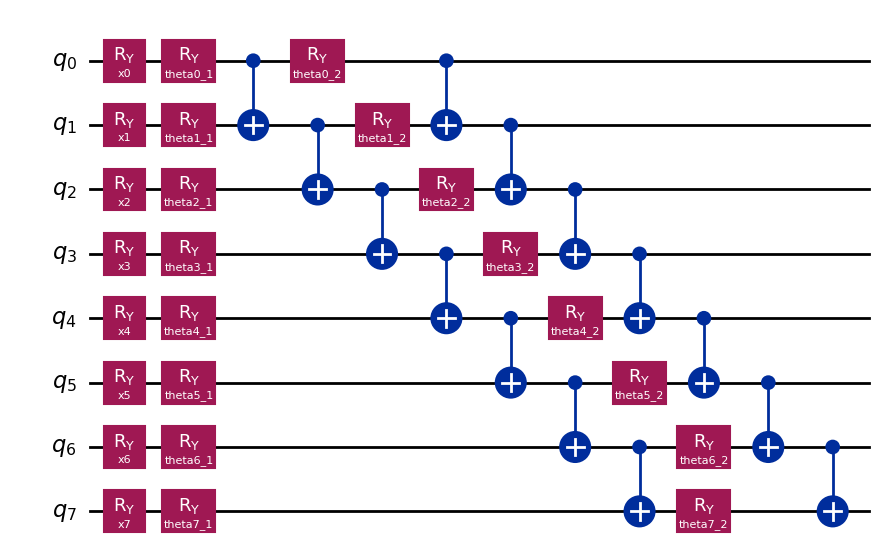

In [8]:
qc.draw(output='mpl')

## 🏗️ Quantum Neural Network (QNN) Construction

In this step, we transform the parameterized quantum circuit (PQC) into a **trainable quantum neural network** that can interface with PyTorch.

### 🔹 Key Components
- **Backend Simulator:**  
  We use `AerSimulator` with the **statevector method** to simulate the quantum circuit on a classical machine.
- **Estimator:**  
  `EstimatorV2` evaluates expectation values of the specified observables for given input and trainable parameters.
- **Gradient Computation:**  
  The **parameter-shift rule** is used to compute gradients for all trainable parameters:
  - For each parameter θ, evaluate the circuit twice: θ + π/2 and θ − π/2.
  - The difference gives the gradient w.r.t. that parameter.
- **EstimatorQNN:**  
  Combines the circuit, estimator, input parameters, weight parameters, and observables into a QNN object.
- **TorchConnector:**  
  Bridges the QNN with PyTorch, allowing seamless integration of the quantum layer into a hybrid classical-quantum model.

### ⚡ Output
- `qnn`: The QNN object for quantum computations and gradient evaluation.
- `qnn_torch`: A PyTorch-compatible module that can be used as a layer in the hybrid neural network.


In [9]:
def build_qnn(qc, x_params, theta_params, observables):
    backend = AerSimulator(method='statevector')  # Quantum simulator backend
    estimator = EstimatorV2(mode=backend)         # Evaluates circuit expectation values

    # Gradient computation using the parameter-shift rule
    # For each trainable parameter, the circuit is evaluated twice:
    # once with the parameter shifted +pi/2, once with -pi/2, then the difference gives the gradient
    gradient = ParamShiftEstimatorGradient(estimator)

    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        input_params=x_params,
        weight_params=theta_params,
        observables=observables,
        gradient=gradient
    )

    qnn_torch = TorchConnector(qnn)  # Link the QNN with PyTorch for hybrid training
    return qnn, qnn_torch

qnn, qnn_torch = build_qnn(qc, x_params, theta_params, observables)

## 🧬 Hybrid Quantum-Classical Model

In this section, we define a **hybrid neural network** that combines the **quantum layer** with classical fully connected layers.

### 🔹 Model Architecture
1. **Quantum Layer (`qlayer`)**  
   - Takes classical input features and outputs **expectation values** from the QNN.  
   - Acts as the first layer in the hybrid model, providing a rich, non-linear quantum embedding of the data.

2. **Classical Hidden Layer (`hidden`)**  
   - Fully connected layer mapping the quantum outputs to a higher-dimensional space (6 neurons).  
   - Uses **ReLU activation** to introduce non-linearity.

3. **Output Layer (`fc`)**  
   - Fully connected layer mapping the hidden representation to **3 output logits** corresponding to the Iris species.  

### ⚡ Training Setup
- **Loss Function:** Cross-entropy loss for multi-class classification.  
- **Optimizer:** Adam optimizer with learning rate defined by `LEARNING_RATE`.  
- **Integration:** The quantum layer is passed into the model during initialization, allowing end-to-end hybrid training with PyTorch.

In [10]:
class HybridModel(nn.Module):
    def __init__(self, qlayer):
        super().__init__()
        self.qlayer = qlayer
        
        # New: Input size must be 1 if observables is a single item (a scalar)
        self.hidden = nn.Linear(1, 8) 
        
        self.relu = nn.ReLU()
        self.fc = nn.Linear(8, 1)

        # Initialize weights
        torch.nn.init.uniform_(self.hidden.weight, -0.1, 0.1)
        torch.nn.init.uniform_(self.fc.weight, -0.1, 0.1)

    def forward(self, x):
        # x shape (batch, 4) -> qlayer(x) shape (batch, 1)
        x = self.qlayer(x) 
        
        # Ensure x is 2D: (batch, 1)
        if x.dim() == 1:
            x = x.unsqueeze(1) 
            
        x = self.hidden(x)
        x = self.relu(x)
        x = self.fc(x)
        return x

model = HybridModel(qlayer=qnn_torch)

In [11]:
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Adam optimizer

## 🏋️ Training the Hybrid Model

We train the hybrid quantum-classical model using mini-batch gradient descent with the **Adam optimizer** and **cross-entropy loss**.  

### 🔹 Training Procedure
1. Iterate over **`EPOCHS`**. For each epoch:
   - Initialize epoch loss and correct prediction counters.
2. Loop over **mini-batches** from the `DataLoader`:
   - Reset gradients (`optimizer.zero_grad()`).
   - Forward pass through the hybrid model (`model(batch_x)`).
   - Compute batch loss and backpropagate (`loss.backward()`).
   - Update model parameters (`optimizer.step()`).
3. Track metrics:
   - **Epoch Loss:** average weighted loss over all training samples.  
   - **Epoch Accuracy:** proportion of correctly classified samples.
4. Log metrics every `LOG_INTERVAL` epochs.

This loop allows **end-to-end training** of both the quantum and classical components of the hybrid network.

In [12]:
from tqdm import tqdm

train_losses = []
train_accuracies = []

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for batch_x, batch_y in loop:
        batch_x = batch_x.float()

        optimizer.zero_grad()

        outputs = model(batch_x)         # shape: (batch, 1)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_x.size(0)

        # ---- FIX 2: Binary predictions using sigmoid ----
        preds = (torch.sigmoid(outputs) > 0.5).float()

        correct += (preds == batch_y).sum().item()
        total += batch_x.size(0)

        loop.set_postfix(loss=epoch_loss / total, acc=correct / total)

    epoch_loss /= total
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    if LOG_INTERVAL is not None and (epoch + 1) % LOG_INTERVAL == 0:
        print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Train Accuracy={epoch_acc:.4f}")

Epoch 1: Loss=0.6946, Train Accuracy=0.4917


Epoch 2: Loss=0.6869, Train Accuracy=0.5579


Epoch 3: Loss=0.6770, Train Accuracy=0.5579


Epoch 4: Loss=0.6567, Train Accuracy=0.5579


Epoch 5: Loss=0.6138, Train Accuracy=0.5579


Epoch 6: Loss=0.5852, Train Accuracy=0.7190


Epoch 7: Loss=0.5706, Train Accuracy=0.7521


Epoch 8: Loss=0.5572, Train Accuracy=0.7521


Epoch 9: Loss=0.5476, Train Accuracy=0.7521


Epoch 10: Loss=0.5367, Train Accuracy=0.7521


Epoch 11: Loss=0.5341, Train Accuracy=0.7521


Epoch 12: Loss=0.5269, Train Accuracy=0.7397


Epoch 13: Loss=0.5227, Train Accuracy=0.7521


Epoch 14: Loss=0.5203, Train Accuracy=0.7521


Epoch 15: Loss=0.5154, Train Accuracy=0.7521


Epoch 16: Loss=0.5170, Train Accuracy=0.7521


Epoch 17: Loss=0.5107, Train Accuracy=0.7521


Epoch 18: Loss=0.5120, Train Accuracy=0.7397


Epoch 19: Loss=0.5079, Train Accuracy=0.7521


Epoch 20: Loss=0.5101, Train Accuracy=0.7521


### 💾 Saving Trained Model and Metrics

After training, we save the **hybrid model parameters** and **training metrics** for future evaluation or reuse, based on the chosen encoding.

### ⚡ Saving Procedure
1. **Model Weights:** saved with `torch.save(model.state_dict(), model_path)`.  
2. **Training Metrics:** loss and accuracy per epoch saved with `np.save(metrics_path, [train_losses, train_accuracies])`.

This ensures **experiment reproducibility** and allows later comparison between plain and richer encodings.

In [13]:
if USE_RICHER_ENCODING:
    model_path = RICH_ENCODING_MODEL_PATH
    metrics_path = RICH_ENCODING_METRICS_PATH
else:
    model_path = PLAIN_ENCODING_MODEL_PATH
    metrics_path = PLAIN_ENCODING_METRICS_PATH

torch.save(model.state_dict(), model_path)
np.save(metrics_path, [train_losses, train_accuracies])

## 🧪 Model Evaluation & Visualization

In this section, we first **set up the evaluation environment** by loading the trained hybrid quantum-classical models (plain and richer encoding) and retrieving the previously saved **training metrics** (losses and accuracies).  

With the models and metrics ready, we perform a comprehensive evaluation and visualization.

### ⚡ What We Do Here
- **Setup & Retrieval:**  
  - Load both hybrid models using `load_hybrid_model`.  
  - Organize them in a dictionary for easy iteration.  
  - Load saved training metrics (losses and accuracies) for plotting and comparison.

- **Training Performance:**  
  - Plot **loss and accuracy curves** for plain vs richer encoding.

- **Test Set Evaluation:**  
  - Compute test accuracy, **confusion matrices**, and **classification reports**.

- **Model Internals Visualization:**  
  - Inspect **quantum layer outputs**.  
  - Compute and visualize **feature saliency maps**.  
  - Analyze **latent embeddings** via PCA.

- **Parameter Sensitivity:**  
  - Examine gradients of trainable parameters to assess their influence on predictions.
 
* **Explainability & Interpretability Metrics:**

  * **Feature Saliency / Average Feature Sensitivity** → highlights which input features most influence model outputs.
  * **Sparseness (L1/L2 ratio)** → quantifies how concentrated or diffuse the saliency map is.
  * **Saliency Entropy** → measures how spread out the saliency values are across features.
  * **Deletion Metric / Fidelity** → tests if removing top-salient features reduces true-class probability.
  * **Bug / Overreliance Detection** → compares saliency for correct vs incorrect predictions to detect misalignment or potential model bias.
  * **Minimum Efficacy** → evaluates if saliency provides information beyond raw model confidence.
  * **Overreliance Risk** → correlation between confidence and fidelity to check if explanations could mislead humans by overstating certainty.

- **Statistical Testing:**  
  - Use the **Wilcoxon signed-rank test** to quantify differences in feature importance between plain and richer encoding.
 
### ⚠️ Note on Classical vs Quantum Metrics

Most of the metrics above are **classical interpretability metrics**, widely established in XAI literature.

* This is because **quantum-specific explainability metrics are still scarce**, and the field lacks standardized methods for analyzing hybrid quantum-classical models.
* Using classical metrics allows us to **evaluate and compare the hybrid models in a rigorous and interpretable way**, even though part of the model is quantum.

In [14]:
def load_hybrid_model(richer_encoding: bool, saved_model_path: str):
    global USE_RICHER_ENCODING
    original_flag = USE_RICHER_ENCODING
    USE_RICHER_ENCODING = richer_encoding

    # Build quantum circuit
    qc, x_params, theta_params, observables = build_quantum_circuit(use_richer_encoding=USE_RICHER_ENCODING)

    # Build QNN and Torch connector
    _, qnn_torch = build_qnn(qc, x_params, theta_params, observables)

    # Create model and attach the quantum layer
    model = HybridModel(qnn_torch)

    # Load saved weights
    model.load_state_dict(torch.load(saved_model_path))
    model.eval()

    # Restore the original flag
    USE_RICHER_ENCODING = original_flag
    return model

# Load trained hybrid models for both encoding types
model_plain = load_hybrid_model(False, PLAIN_ENCODING_MODEL_PATH)
model_rich  = load_hybrid_model(True, RICH_ENCODING_MODEL_PATH)

# Organize models in a dictionary for convenience
models = {"Plain Encoding": model_plain, "Richer Encoding": model_rich}

# Load previously saved training metrics (losses and accuracies)
plain_losses, plain_acc = np.load(PLAIN_ENCODING_METRICS_PATH + ".npy", allow_pickle=True)
rich_losses, rich_acc   = np.load(RICH_ENCODING_METRICS_PATH + ".npy", allow_pickle=True)

RuntimeError: Error(s) in loading state_dict for HybridModel:
	size mismatch for qlayer.weight: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for qlayer._weights: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for hidden.weight: copying a param with shape torch.Size([6, 4]) from checkpoint, the shape in current model is torch.Size([8, 1]).
	size mismatch for hidden.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for fc.weight: copying a param with shape torch.Size([3, 6]) from checkpoint, the shape in current model is torch.Size([1, 8]).
	size mismatch for fc.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([1]).

### 📈 Training Loss and Accuracy Comparison

This plot shows the **training performance** of the hybrid models for both **plain** and **richer encoding** schemes.

- **Left Plot — Training Loss:**  
  Visualizes how the cross-entropy loss decreases over epochs for each model. Lower values indicate better learning.

- **Right Plot — Training Accuracy:**  
  Shows the proportion of correctly classified training samples per epoch. Higher values indicate better model performance.

By comparing these curves, we can see the **impact of richer encoding** on learning speed and stability.

In [ ]:
plt.figure(figsize=(10,4))

# Training Loss
plt.subplot(1,2,1)
plt.plot(plain_losses, label="Plain Encoding")
plt.plot(rich_losses, label="Richer Encoding")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()

# Training Accuracy
plt.subplot(1,2,2)
plt.plot(plain_acc, label="Plain Encoding")
plt.plot(rich_acc, label="Richer Encoding")
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()

plt.tight_layout()
plt.show()

### 🧩 Test Accuracy and Confusion Matrices

In this section, we **evaluate the trained hybrid models** on the test set and visualize their performance.

- **Test Accuracy:**  
  Prints the overall accuracy for each model (plain vs richer encoding).

- **Confusion Matrices:**  
  Show how well each model predicts each Iris species.  
  - Diagonal values: correctly classified samples  
  - Off-diagonal values: misclassifications  

This visualization allows quick comparison of **classification strengths and weaknesses** between the two encoding approaches.

In [ ]:
plt.figure(figsize=(12,5))

for i, (name, mdl) in enumerate(models.items()):
    with torch.no_grad():  # Disable gradient computation for evaluation
        outputs = mdl(X_test)                 # Forward pass on test set
        _, preds = torch.max(outputs, 1)      # Get predicted class labels
        test_acc = (preds == y_test).float().mean().item()  # Compute test accuracy
        print(f"{name} - Test Accuracy: {test_acc:.4f}")

        # Compute and display the confusion matrix
        cm = confusion_matrix(y_test.numpy(), preds.numpy())
        plt.subplot(1, 2, i+1)  # Place the plot in the correct subplot
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
        disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)  # Draw the confusion matrix
        plt.title(f"{name} Confusion Matrix")

plt.tight_layout()
plt.show()

### 📊 Classification Reports

This section provides **detailed evaluation metrics** for each model on the test set:

- **Precision:** proportion of correct positive predictions per class.  
- **Recall:** proportion of actual positives correctly identified per class.  
- **F1-score:** harmonic mean of precision and recall.  
- **Support:** number of samples for each class.  

Comparing the reports for **plain vs richer encoding** helps identify which Iris species each model classifies better or struggles with.

In [ ]:
for name, mdl in models.items():
    with torch.no_grad():  # Disable gradient computation for evaluation
        outputs = mdl(X_test)                 # Forward pass on test set
        _, preds = torch.max(outputs, 1)      # Get predicted class labels
    
    # Print detailed classification metrics
    print(f"\n{name} Classification Report:")
    print(classification_report(
        y_test,                               # True labels
        preds,                                # Predicted labels
        target_names=iris.target_names        # Human-readable class names
    ))

### ⚛️ Quantum Layer Outputs

This section visualizes the **expectation values from the quantum layer** for each test sample:

- **Heatmap:** each row corresponds to a test sample, each column to a qubit.  
- **Color intensity:** represents the magnitude of the quantum expectation value.  

Comparing the heatmaps for **plain vs richer encoding** gives insight into how the encoding strategy affects the quantum feature representation.

In [ ]:
plt.figure(figsize=(12,4))

for i, (name, mdl) in enumerate(models.items()):
    # Get the output of the quantum layer (expectation values) for all test samples
    q_outputs = qnn_torch(X_test).detach().numpy()
    
    plt.subplot(1,2,i+1)
    plt.imshow(
        q_outputs,
        cmap='viridis',
        aspect='auto',
        extent=[0, q_outputs.shape[1]-1, 0, q_outputs.shape[0]-1]  # qubits on x, samples on y
    )
    plt.colorbar(label="Quantum Expectation Value")
    plt.title(f"{name} Quantum Layer Outputs")
    plt.xlabel("Qubits")
    plt.ylabel("Samples")
    plt.gca().invert_yaxis()  # optional: have first sample at the top

plt.tight_layout()
plt.show()

### 🔍 Feature Saliency Analysis

This section analyzes **how sensitive the model outputs are to each input feature**:

- **Saliency Maps:**  
  - Computed using a finite difference method: perturb each feature slightly and observe the change in output.  
  - Rows = test samples, columns = features.  
  - Color intensity indicates how strongly the model output responds to that feature.

- **Average Feature Saliency:**  
  - Aggregates the saliency values across all samples for each feature.  
  - Bar plots allow direct comparison of **plain vs richer encoding** models.  

Insights:  
- Features with higher saliency are more important for the model’s decision.  
- Differences between plain and richer encoding indicate how the extra RZ rotations influence feature representation.

In [ ]:
def compute_saliency(model, inputs, delta=1e-3):
    model.eval()  # Set model to evaluation mode
    inputs = inputs.clone().detach()  # Avoid modifying original data
    base_output = model(inputs).detach().numpy()  # Base model output
    saliency = np.zeros_like(inputs)  # Initialize saliency array

    for feature_idx in range(inputs.shape[1]):
        # Perturb one feature at a time
        perturbed = inputs.clone()
        perturbed[:, feature_idx] += delta
        
        # Compute model output for perturbed input
        perturbed_output = model(perturbed).detach().numpy()
        
        # Estimate gradient via finite difference
        grad_estimate = (perturbed_output - base_output) / delta
        
        # Aggregate absolute gradient across output dimensions
        saliency[:, feature_idx] = np.mean(np.abs(grad_estimate), axis=1)
    
    return saliency

# Compute saliency maps for both models
saliency_plain = compute_saliency(model_plain, X_test)
saliency_rich  = compute_saliency(model_rich, X_test)

# ----- Plot saliency maps side-by-side -----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(saliency_plain, cmap='hot', aspect='auto')
plt.colorbar(label="Feature Sensitivity")
plt.title("Saliency Map: Plain Encoding")
plt.xticks(range(X_test.shape[1]), iris.feature_names, rotation=45)
plt.ylabel("Samples")

plt.subplot(1,2,2)
plt.imshow(saliency_rich, cmap='hot', aspect='auto')
plt.colorbar(label="Feature Sensitivity")
plt.title("Saliency Map: Richer Encoding")
plt.xticks(range(X_test.shape[1]), iris.feature_names, rotation=45)
plt.ylabel("Samples")

plt.tight_layout()
plt.show()

# ----- Average feature saliency comparison -----
mean_plain = saliency_plain.mean(axis=0)
mean_rich  = saliency_rich.mean(axis=0)

plt.figure(figsize=(8,4))
x = np.arange(len(iris.feature_names))
width = 0.35
plt.bar(x - width/2, mean_plain, width, label="Plain")
plt.bar(x + width/2, mean_rich, width, label="Richer")
plt.xticks(x, iris.feature_names, rotation=45)
plt.ylabel("Average Saliency")
plt.title("Average Feature Sensitivity Comparison")
plt.legend()
plt.tight_layout()
plt.show()


### 🧪 Average Sensitivity (Stability of Explanations)

This section evaluates **how stable the model’s saliency explanations are** under small perturbations of the input.

* **Purpose:**
  Average Sensitivity measures whether tiny random changes to the input cause large changes in the saliency values.
  A good explanation method should be **stable** e.g. small input noise should not radically alter which features appear important.

* **Method:**

  1. Compute the original saliency map for the model.
  2. Add a very small random perturbation (Gaussian noise scaled by `δ`) to each input sample.
  3. Recompute the saliency on the perturbed input.
  4. Measure the **mean absolute difference** between the two saliency maps.

* **Interpretation:**

  * **Low Average Sensitivity** -> robust, stable explanations.
  * **High Average Sensitivity** -> explanations are fragile and inconsistent.
  * Comparing values for **plain** vs **richer encoding** reveals whether the richer architecture produces more reliable feature attributions.

This metric helps ensure that saliency-based explanations are not just accurate but also **consistent**, which is critical for human trust and interpretability.

In [ ]:
def average_sensitivity(model, inputs, delta=1e-3, saliency_fn=compute_saliency):
    # Original saliency
    saliency_orig = saliency_fn(model, inputs, delta)
    
    # Add small random noise to inputs
    noise = torch.randn_like(inputs) * delta
    inputs_perturbed = inputs + noise
    
    # Saliency for perturbed inputs
    saliency_perturbed = saliency_fn(model, inputs_perturbed, delta)
    
    # Compute average absolute difference
    avg_sens = np.mean(np.abs(saliency_orig - saliency_perturbed))
    return avg_sens

avg_sens_plain = average_sensitivity(model_plain, X_test)
avg_sens_rich  = average_sensitivity(model_rich, X_test)

print("Average Sensitivity (Plain):", avg_sens_plain)
print("Average Sensitivity (Richer):", avg_sens_rich)

### ✂️ Deletion Metric (Faithfulness of Saliency)

The **Deletion Metric** evaluates **how faithfully the saliency map reflects the model’s true decision process**.

* **Purpose:**
  If a saliency method correctly identifies the most important features, then **removing those features should significantly reduce the model's confidence** in the true class.

* **Method:**

  1. Rank features for each sample by saliency (highest -> lowest importance).
  2. Iteratively delete the top-*k* most salient features by setting them to zero.
  3. Measure how much the model’s **true-class probability** decreases as more salient features are removed.
  4. Repeat for *k = 1 … 5* and average across the dataset.

* **Interpretation:**

  * A **good saliency method** produces a **steep deletion curve** e.g. removing the “most important” features should sharply reduce confidence.
  * A **flat curve** indicates that the saliency does **not** correspond to the real decision-making process.
  * Comparing deletion curves for the **plain** vs **richer encoding** models reveals which one depends more transparently on its salient features.

* **Observed Behavior (Important Insight):**
  In our case:

  * **Plain Encoding:** Confidence drops sharply from ~0.38 to 0.21 after removing the top 1–2 features, then stabilizes around ~0.30 for *k = 3–5*.
  * **Richer Encoding:** Confidence starts higher (~0.50), drops to ~0.34 for k=2, reaches ~0.25 for k=3, then stabilizes around ~0.30 for k=4–5.

  This indicates that:

  * Both models rely primarily on the **top 1-2 features**.
  * Once the key features are removed, additional deletions do **not** significantly affect confidence.
  * The richer model’s top features are slightly more informative individually (higher initial confidence), but both models show a plateau after removing the most important features.

  This is a **desirable behavior**, showing that the saliency maps faithfully identify the features most critical for the model’s predictions, and once removed, the models fall back to near-baseline confidence.

* **Visualization:**
  The plot shows:

  * **x-axis:** number of removed top-salient features
  * **y-axis:** remaining probability for the true class

  A model with more faithful saliency explanations will have a **more rapidly decreasing** curve, especially in the first 1–2 feature removals, before stabilizing as the remaining features carry little additional information.

In [ ]:
def deletion_score(model, inputs, labels, saliency, steps=5):
    inputs_copy = inputs.clone()
    scores = []

    for k in range(1, steps+1):
        # Determine top-k features for each sample
        topk = np.argsort(-saliency, axis=1)[:, :k]  # descending order
        modified = inputs_copy.clone()
        
        # Zero-out top-k features
        for i in range(modified.shape[0]):
            modified[i, topk[i]] = 0.0
        
        # Get predicted probabilities for true class
        with torch.no_grad():
            outputs = model(modified)
            probs = torch.softmax(outputs, dim=1)
            true_class_probs = probs[range(len(labels)), labels].numpy()
        scores.append(true_class_probs.mean())
    
    return scores

labels_test = y_test.clone().detach().long()
deletion_plain = deletion_score(model_plain, X_test, labels_test, saliency_plain)
deletion_rich  = deletion_score(model_rich, X_test, labels_test, saliency_rich)

# Plot deletion curves
plt.figure(figsize=(8,4))
plt.plot(range(1,6), deletion_plain, marker='o', label="Plain")
plt.plot(range(1,6), deletion_rich, marker='o', label="Richer")
plt.xlabel("Number of Most Salient Features Removed")
plt.ylabel("Average True Class Probability")
plt.title("Deletion Metric")
plt.legend()
plt.show()

### 🧩 Saliency Sparseness (Conciseness of Explanations)

The **Saliency Sparseness** metric evaluates **how concentrated or distributed the saliency values are across input features**.

* **Purpose:**
  A sparse explanation highlights a **small number of highly important features**, which can improve interpretability and make explanations easier for humans to understand.
  Conversely, a dense explanation spreads importance across many features, making it harder to discern which features truly matter.

* **Method:**

  1. Compute the **L1 norm** of the saliency map (sum of absolute values).
  2. Compute the **L2 norm** of the saliency map (square root of sum of squares).
  3. Define sparsity as:

$$
\text{Sparsity} = \frac{||\text{saliency}||_1}{||\text{saliency}||_2 + \epsilon}
$$

  * Lower values indicate **higher sparsity** (more focused explanations).
  * Higher values indicate **less sparse** explanations (spread-out feature importance).

* **Interpretation:**

  * **Low Sparseness** → the model’s saliency focuses on a few key features → easier to understand and trust.
  * **High Sparseness** → the model distributes importance across many features → may indicate redundant or entangled feature use.
  * Comparing the **plain** vs **richer encoding** models shows whether richer representations produce more concentrated or more distributed explanations. We observe that the plain encoding has a more concentrated explanation.

In [ ]:
def saliency_sparseness(saliency):
    l1 = np.sum(np.abs(saliency))
    l2 = np.sqrt(np.sum(saliency**2))
    return l1 / (l2 + 1e-12)

sparse_plain = saliency_sparseness(saliency_plain)
sparse_rich  = saliency_sparseness(saliency_rich)

print("Sparseness (Plain):", sparse_plain)
print("Sparseness (Rich):", sparse_rich)

### 📊 Saliency Entropy (Complexity of Explanations)

The **Saliency Entropy** metric measures **how spread out or concentrated the feature importance is across input features**, providing a complementary view to sparsity.

* **Purpose:**
  Entropy captures the **overall complexity** of the saliency distribution:

  * Low entropy → most importance is concentrated on a few features → simple and concise explanations
  * High entropy → importance is spread across many features → more complex and potentially harder to interpret explanations

* **Method:**

  1. Compute the **mean saliency** for each feature across all samples.
  2. Normalize to get a probability distribution.
  3. Compute the **Shannon entropy** of this distribution:

  $$
  H = - \sum_i p_i \log(p_i)
  $$

* **Interpretation:**

  * **Low entropy** → explanations are focused, highlighting a few key features.
  * **High entropy** → explanations are distributed, indicating the model relies on multiple features or has entangled representations.
  * Comparing **plain** vs **richer encoding** models shows which produces simpler, more concise explanations. As we can observe, while the entropies are similar, the plain encoding produces a lower entropy and thus leading to a simpler and more concise explanation.

In [ ]:
def saliency_entropy(saliency):
    mean_sal = saliency.mean(axis=0)
    p = mean_sal / (mean_sal.sum() + 1e-12)
    return entropy(p)

entropy_plain = saliency_entropy(saliency_plain)
entropy_rich  = saliency_entropy(saliency_rich)

print("Entropy (Plain):", entropy_plain)
print("Entropy (Richer):", entropy_rich)

### 🐞 Bug Detection Signal (Saliency vs Misclassifications)

The **Bug Detection Signal** evaluates **how well the saliency map differentiates between correct and incorrect predictions**, providing insight into whether the saliency highlights problematic areas when the model makes mistakes.

* **Purpose:**
  If a saliency method is faithful, **incorrect predictions should show higher saliency on features that contributed to the error**, while correct predictions should show lower saliency magnitude on misleading features. This helps identify where the model relies on the wrong cues.

* **Method:**

  1. Compute model predictions and identify **correct vs incorrect predictions**:
  2. Compute the **average saliency magnitude** for:

     * Correctly classified samples → `sal_correct`
     * Incorrectly classified samples → `sal_incorrect`

  3. Calculate the **ratio**:
     * Higher ratios indicate that saliency is stronger for misclassified samples, highlighting features that may have led to errors.
     * Low or zero ratios indicate minimal difference between correct and incorrect samples.

* **Observed Behavior:**
  Across multiple runs:

  * **Plain Encoding:** Ratio is usually **0.0**, indicating that the model rarely highlights errors via its saliency — most saliency is focused on correct predictions or the errors are minimal.
  * **Richer Encoding:** Ratio is sometimes **0.0**, but more often a small value (~0.5), showing that the richer model’s saliency captures **features contributing to misclassifications** more reliably.

* **Interpretation:**

  * A **non-zero ratio** suggests the saliency map provides useful signals for debugging and understanding model mistakes.
  * The richer encoding appears slightly **more informative for error analysis**, as its saliency better differentiates correct from incorrect predictions.
  * The plain encoding produces mostly zero ratios, indicating less guidance for identifying problematic features.

In [ ]:
def bug_detection_signal(model, inputs, labels, saliency):
    preds = model(inputs).argmax(dim=1).detach().cpu().numpy()
    labels = labels if isinstance(labels, np.ndarray) else labels.detach().cpu().numpy()
    errors = preds != labels

    # Avg saliency magnitude for correct vs incorrect predictions
    if (~errors).any():
        sal_correct = saliency[~errors].mean()
    else:
        sal_correct = 0.0

    if errors.any():
        sal_incorrect = saliency[errors].mean()
    else:
        sal_incorrect = 0.0

    ratio = sal_incorrect / (sal_correct + 1e-12)
    
    return {
        "correct_mean_saliency": sal_correct,
        "incorrect_mean_saliency": sal_incorrect,
        "ratio": ratio
    }

bug_plain = bug_detection_signal(model_plain, X_test, y_test, saliency_plain)
bug_rich  = bug_detection_signal(model_rich, X_test, y_test, saliency_rich)

def print_bug_signal(name, result):
    print(f"--- {name} ---")
    print(f"Average saliency (correct predictions)  : {result['correct_mean_saliency']:.4f}")
    print(f"Average saliency (incorrect predictions): {result['incorrect_mean_saliency']:.4f}")
    print(f"Ratio (incorrect / correct)             : {result['ratio']:.4f}\n")

print_bug_signal("Plain Encoding", bug_plain)
print_bug_signal("Richer Encoding", bug_rich)

### ⚠️ Overreliance Risk (Reliability of Saliency Beyond Confidence)

The **Overreliance Risk** metric evaluates **whether the saliency map provides useful information beyond the model’s raw confidence**, helping to identify if users might be misled by overconfident predictions.

* **Purpose:**
  Even if a model is confident, a faithful saliency map should **highlight features that truly influence the prediction**.
  If saliency is weakly aligned with prediction changes, users could **overtrust the model**, relying on confidence alone rather than the explanation.

* **Method:**

  1. Compute **per-sample deletion fidelity**:

     * For each sample, remove the top-*k* most salient features (here *k = 1*).
     * Measure the **drop in probability** for the true class:

     $$
     \text{fidelity}*i = p*{\text{true, original}} - p_{\text{true, after deletion}}
     $$

  2. Compute the **model’s confidence** per sample:

     $$
     \text{confidence}*i = \max_j p*{i,j}
     $$

  3. Define **overreliance risk** as the correlation between confidence and **negative fidelity**:

     $$
     \text{Risk} = \text{corr}(\text{confidence}, -\text{fidelity})
     $$

     * A **positive correlation** → high confidence but weak fidelity → **high risk of misleading explanations**.
     * A **negative or near-zero correlation** → low risk → saliency correctly indicates feature importance beyond mere confidence.

* **Observed Behavior:**

  ```
  Overreliance Risk (Plain) : -0.168
  Overreliance Risk (Richer): -0.164
  ```

  * Both values are slightly negative, indicating **low risk** of users being misled by overconfident predictions.
  * The richer encoding shows similar behavior to the plain encoding, suggesting its explanations are **equally reliable** in highlighting influential features beyond model confidence.

* **Interpretation:**

  * Negative values → confident predictions generally correspond to meaningful saliency drops when top features are deleted.
  * The metric complements **Deletion Fidelity**, confirming that the saliency map is not simply reflecting the model’s raw confidence but faithfully indicates **which features truly matter**.

In [ ]:
def deletion_fidelity_per_sample(model, inputs, saliency, labels, k=1):
    """
    k = how many top features to delete per sample
    returns a vector of length N (one fidelity score per sample)
    """
    N, F = inputs.shape

    # base confidence for true class
    with torch.no_grad():
        base_probs = torch.softmax(model(inputs), dim=1)
        base_conf = base_probs[np.arange(N), labels].cpu().numpy()

    # output array
    fidelity = np.zeros(N)

    for i in range(N):
        # sort features by saliency descending
        topk = np.argsort(-saliency[i])[:k]

        # delete features
        x_mod = inputs[i].clone()
        x_mod[topk] = 0.0

        with torch.no_grad():
            out = model(x_mod.unsqueeze(0))
            prob = torch.softmax(out, dim=1)[0, labels[i]].item()

        fidelity[i] = base_conf[i] - prob  # confidence drop
    
    return fidelity

def overreliance_risk(confidence, fidelity):
    # risk = positive correlation → high risk of misleading confidence
    return np.corrcoef(confidence, -fidelity)[0, 1]


# --- Compute fidelity for both models ---
fidelity_plain = deletion_fidelity_per_sample(model_plain, X_test, saliency_plain, y_test, k=1)
fidelity_rich  = deletion_fidelity_per_sample(model_rich,  X_test, saliency_rich,  y_test, k=1)

# --- Compute confidence per sample ---
with torch.no_grad():
    probs_plain = torch.softmax(model_plain(X_test), dim=1)
    conf_plain  = probs_plain.max(dim=1).values.numpy()

    probs_rich = torch.softmax(model_rich(X_test), dim=1)
    conf_rich  = probs_rich.max(dim=1).values.numpy()

# --- Compute overreliance risk ---
risk_plain = overreliance_risk(conf_plain, fidelity_plain)
risk_rich  = overreliance_risk(conf_rich, fidelity_rich)

print("Overreliance Risk (Plain):", risk_plain)
print("Overreliance Risk (Rich):",  risk_rich)

### 📈 Minimum Efficacy (Saliency Beyond Confidence)

The **Minimum Efficacy** metric evaluates **whether saliency maps provide additional explanatory power beyond the model’s raw confidence**, ensuring that explanations are meaningful even when predictions are highly confident.

* **Purpose:**

  * Saliency maps should highlight **which features drive predictions**, not just reflect the model’s confidence.
  * A faithful saliency method increases **trust and interpretability**, while low or misleading efficacy could overemphasize confidence rather than true feature importance.

* **Method:**

  1. Compute **predictions** and a correctness vector:

     * `1` → correct prediction
     * `0` → incorrect prediction

     ```python
     correct = (preds == labels).astype(int)
     ```

  2. Compute **baseline confidence** per sample:

     * Maximum probability assigned by the model to any class.

  3. Compute **saliency signal**:

     * Mean absolute saliency per sample.

  4. Calculate **ROC AUC** for:

     * Confidence vs correctness
     * Saliency vs correctness

  5. **Saliency Gain** = `AUC(saliency) - AUC(confidence)`

     * Positive → saliency provides additional discriminative power beyond confidence
     * Negative → saliency adds little or potentially misleading information

* **Implementation Note:**

  * If the test set contains only **one class in the correctness vector**, ROC AUC is undefined. In such cases, the metric returns `nan` instead of raising a warning.

* **Observed Results:**

```
--- Plain Encoding ---
AUC (Confidence) : nan
AUC (Saliency)   : nan
Saliency Gain    : nan

--- Richer Encoding ---
AUC (Confidence) : 1.0000
AUC (Saliency)   : 0.8621
Saliency Gain    : -0.1379
```

* **Interpretation:**

  * **Plain Encoding:**

    * `nan` indicates that the correctness vector contained only **one class** — all predictions were either correct or incorrect.
    * This is **informative about the model**: it is very consistent and confident.
    * Since there is no variation in correctness, saliency efficacy **cannot be evaluated** via ROC AUC, but the behavior itself highlights the model’s uniform decision pattern.

  * **Richer Encoding:**

    * Confidence AUC = 1.0 → the model predicts correctly with **perfect confidence**.
    * Saliency AUC = 0.8621 → saliency is **informative but not perfectly aligned** with correctness.
    * Saliency Gain = -0.1379 → saliency adds slightly less discriminative power than raw confidence alone.

  * **Overall Insight:**

    * Minimum Efficacy reveals **differences in both model behavior and saliency quality**.
    * `nan` values can be **meaningful**, indicating highly consistent predictions, not just missing data.
    * Negative saliency gain shows that even when predictions are confident, saliency maps may **underrepresent certain important features**, pointing to potential areas for improving explanation fidelity.

In [ ]:
def safe_roc_auc(y_true, y_score):
    if len(np.unique(y_true)) < 2:
        return float('nan')  # cannot compute ROC AUC
    return roc_auc_score(y_true, y_score)
    
def minimum_efficacy(model, inputs, labels, saliency):
    # predictions
    preds = model(inputs).argmax(dim=1).cpu().numpy()
    labels_np = labels.cpu().numpy()

    # correctness vector: 1 = correct, 0 = wrong
    correct = (preds == labels_np).astype(int)

    # baseline confidence
    with torch.no_grad():
        probs = torch.softmax(model(inputs), dim=1).cpu().numpy()
    conf = probs[np.arange(len(labels_np)), preds]

    # saliency signal (mean absolute saliency per sample)
    sal_signal = saliency.mean(axis=1)

    # handle single-class case
    try:
        auc_conf = safe_roc_auc(correct, conf)
    except ValueError:
        auc_conf = float('nan')

    try:
        auc_sal = safe_roc_auc(correct, sal_signal)
    except ValueError:
        auc_sal = float('nan')

    return {
        "auc_confidence": auc_conf,
        "auc_saliency": auc_sal,
        "saliency_gain": auc_sal - auc_conf if not (np.isnan(auc_conf) or np.isnan(auc_sal)) else float('nan')
    }

# Compute minimum efficacy for both models
min_eff_plain = minimum_efficacy(model_plain, X_test, y_test, saliency_plain)
min_eff_rich  = minimum_efficacy(model_rich, X_test, y_test, saliency_rich)

def print_min_eff(name, result):
    print(f"--- {name} ---")
    print(f"AUC (Confidence) : {result['auc_confidence']:.4f}" if not np.isnan(result['auc_confidence']) else "AUC (Confidence) : nan")
    print(f"AUC (Saliency)   : {result['auc_saliency']:.4f}"   if not np.isnan(result['auc_saliency']) else "AUC (Saliency)   : nan")
    print(f"Saliency Gain    : {result['saliency_gain']:.4f}"   if not np.isnan(result['saliency_gain']) else "Saliency Gain    : nan\n")

print_min_eff("Plain Encoding", min_eff_plain)
print_min_eff("Richer Encoding", min_eff_rich)

### 🧠 Quantum Embedding Visualization (PCA)

This section visualizes the **quantum layer outputs** in 2D using **Principal Component Analysis (PCA)**:

- Each point represents a test sample in the **quantum feature space**.  
- Color corresponds to the **true class** of the sample.  
- Comparing the two plots shows how the **plain vs richer encoding** affects the separation of classes:
  - **Plain Encoding:** simpler mapping, possibly more overlapping clusters.  
  - **Richer Encoding:** extra RZ rotations provide a more expressive embedding, which can lead to better class separation.  

This visualization helps intuitively understand why richer encoding may improve classification performance.

In [ ]:
def visualize_latent(model, name):
    with torch.no_grad():
        # Get quantum layer outputs for all test samples
        latent = model.qlayer(X_test).detach().numpy()
    
    # Reduce dimensionality to 2D for visualization
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent)
    
    # Scatter plot: each point = one sample, colored by true class
    plt.scatter(latent_2d[:,0], latent_2d[:,1], c=y_test, cmap='viridis')
    plt.title(f"Quantum Embedding (PCA) - {name}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

# Plot side-by-side for plain vs richer encoding
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
visualize_latent(model_plain, "Plain Encoding")
plt.subplot(1,2,2)
visualize_latent(model_rich, "Richer Encoding")
plt.tight_layout()
plt.show()

### ⚡ Parameter Sensitivity Analysis

This section evaluates how sensitive the model outputs are to changes in **each trainable parameter**:

- **Gradient Magnitude:**  
  - The gradient of the loss w.r.t. each parameter tensor is computed on the test set.  
  - Larger gradients indicate parameters that strongly influence the model’s predictions.

- **Purpose:**  
  - Compare **plain vs richer encoding** to see how additional quantum gates affect parameter sensitivity.  
  - Parameters with consistently higher gradients may be more important for model performance.

- **Visualization:**  
  - Each bar represents the **average absolute gradient of a full parameter tensor**, not individual weights.  
  - The hybrid model has 5 trainable tensors:
    1. QNN trainable parameters (theta)  
    2. Hidden layer weights  
    3. Hidden layer biases  
    4. Output layer weights  
    5. Output layer biases  
  - Multiple bars (side-by-side) allow direct comparison between the two models.  

In [ ]:
plt.figure(figsize=(10,4))

for i, (name, mdl) in enumerate(models.items()):
    mdl.train()  # Enable gradient computation for parameter sensitivity
    
    # Temporary optimizer for backward pass (not actually training)
    optimizer = torch.optim.Adam(mdl.parameters())
    optimizer.zero_grad()
    
    # Forward pass on the test set
    outputs = mdl(X_test)
    loss = criterion(outputs, y_test)
    
    # Backward pass to compute gradients
    loss.backward()
    
    # Collect average gradient magnitudes for each parameter
    grads = []
    for param in mdl.parameters():
        if param.requires_grad and param.grad is not None:
            grads.append(param.grad.detach().abs().mean().item())
    
    # Plot the average gradients for each parameter
    plt.bar(np.arange(len(grads)) + i*0.4, grads, width=0.4, label=name)

plt.xlabel("Parameters (theta & classical layer)")
plt.ylabel("Average Gradient Magnitude")
plt.title("Parameter Sensitivity (Gradient Proxy)")
plt.legend()
plt.show()

### 📊 Wilcoxon Test: Feature Saliency Comparison

This section statistically compares the **feature saliency** between the **plain** and **richer encoding** models using the **Wilcoxon signed-rank test**:

- **Purpose:**  
  - Determine whether adding richer quantum encoding significantly changes the sensitivity of the model to each input feature.
  
- **Procedure:**  
  1. For each feature, extract saliency values (sensitivity) from both models.  
  2. Apply the Wilcoxon signed-rank test to check for differences between the paired distributions.  
  3. Mark features with `p < 0.05` as statistically significant (`*`).

- **Interpretation:**  
  - A significant result (`*`) suggests that the feature's influence on the model output differs between plain and richer encoding.

In [ ]:
print("Wilcoxon Test: Plain vs Richer Encoding Feature Saliency\n")

for feature_idx, feature_name in enumerate(iris.feature_names):
    # Extract saliency values for the current feature for both models
    plain_vals = saliency_plain[:, feature_idx]
    rich_vals  = saliency_rich[:, feature_idx]
    
    # Perform Wilcoxon signed-rank test to compare the two distributions
    stat, p = wilcoxon(plain_vals, rich_vals)
    
    # Mark statistically significant differences
    sig = "*" if p < 0.05 else ""
    
    # Print results
    print(f"{feature_name:15}: stat={stat:.4f}, p={p:.4f} {sig}")